## Load Data

In [1]:
from src.utils import load_replay_buffer_and_kernel

FOLDER_NAME: str="data/local/experiment/circle_rotation"
TASK_NAMES=["sac_circle_rotation_task_0", "sac_circle_rotation_task_1", "sac_circle_rotation_task_2", "sac_circle_rotation_task_3"]

LOAD_WHAT:str="next_observations"
KERNEL_DIM=1
N_SAMPLES=50_000

tasks_ps, tasks_frameestimators=[], []
for task_name in TASK_NAMES:
    ps, frameestimator = load_replay_buffer_and_kernel(task_name, LOAD_WHAT, KERNEL_DIM, N_SAMPLES, FOLDER_NAME)
    tasks_ps.append(ps)
    tasks_frameestimators.append(frameestimator)

2025-07-16 10:10:14.513489: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/utils.py:100: UserWarning: Replay buffer contains more samples than selected.
  warnings.warn("Replay buffer contains more samples than selected.")


Loaded next_observations from data/local/experiment/circle_rotation/sac_circle_rotation_task_0_replay_buffer.pkl with shape torch.Size([100000, 2])


INFO:root:Setup kernel frame evaluation.


Loaded next_observations from data/local/experiment/circle_rotation/sac_circle_rotation_task_1_replay_buffer.pkl with shape torch.Size([100000, 2])


INFO:root:Setup kernel frame evaluation.


Loaded next_observations from data/local/experiment/circle_rotation/sac_circle_rotation_task_2_replay_buffer.pkl with shape torch.Size([100000, 2])


INFO:root:Setup kernel frame evaluation.


Loaded next_observations from data/local/experiment/circle_rotation/sac_circle_rotation_task_3_replay_buffer.pkl with shape torch.Size([100000, 2])


INFO:root:Setup kernel frame evaluation.


In [8]:
import wandb
%load_ext autoreload
%autoreload 2

import torch
from src.learning.symmetry.hereditary_geometry_discovery import HereditaryGeometryDiscovery
from src.utils import Affine2D


train_goal_locations=[
    {'goal': torch.tensor([-0.70506063,  0.70914702])},
 {'goal': torch.tensor([ 0.95243384, -0.30474544])},
 {'goal': torch.tensor([-0.11289421, -0.99360701])},
 {'goal': torch.tensor([-0.81394263, -0.58094525])}]

SEED=42
LEARN_LEFT_ACTIONS=True
LEARN_GENERATOR=True
LEARN_ENCODER_DECODER=True
USE_ORACLE_ROTATION_KERNEL=True
N_STEPS=150_000
BATCH_SIZE=128
BANDWIDTH=None
LEARNING_RATE_LEFT_ACTIONS=0.00035
LEARNING_RATE_GENERATOR=0.00035
lr_chart=0.00015
update_chart_every_n_steps=150
N_STEPS_PRETRAIN_GEOMETRY=10_000

ENCODER=Affine2D(input_dim=2, output_dim=2)
DECODER=Affine2D(input_dim=2, output_dim=2)
ORACLE_GENERATOR=torch.tensor([[0, -1], [1,0]], dtype=torch.float32, requires_grad=False).unsqueeze(0) if not LEARN_GENERATOR else None

WAND_PROJECT_NAME="circle_hereditary_geometry_discovery"

wandb.init(project=WAND_PROJECT_NAME, name=f"lr_chart:{lr_chart}_update_n:{update_chart_every_n_steps}",config={
    "n_steps": N_STEPS,
    "batch_size": BATCH_SIZE,
    "kernel_dim": KERNEL_DIM,
    "bandwidth": BANDWIDTH,
    "learn_encoder_decoder": LEARN_ENCODER_DECODER,
    "learn_left_actions": LEARN_LEFT_ACTIONS,
    "learn_generator": LEARN_GENERATOR,
    "seed": SEED,
    "use_oracle_rotation_kernel": USE_ORACLE_ROTATION_KERNEL,
    "learning_rate_left_actions": LEARNING_RATE_LEFT_ACTIONS,
    "learning_rate_generator": LEARNING_RATE_GENERATOR,
    "learning_rate_encoder": lr_chart,
    "learning_rate_decoder": lr_chart,
    "update_chart_every_n_steps": update_chart_every_n_steps,
    "n_steps_pretrain_geometry": N_STEPS_PRETRAIN_GEOMETRY,
}, reinit=True)

her_geo_dis=HereditaryGeometryDiscovery(tasks_ps=tasks_ps,
                                        tasks_frameestimators=tasks_frameestimators, 
                                        kernel_dim=KERNEL_DIM, 
                                        batch_size=BATCH_SIZE, 
                                        seed=SEED, 
                                        bandwidth=BANDWIDTH,
                                        log_wandb=True,
                                        learn_encoder_decoder=LEARN_ENCODER_DECODER,
                                        use_oracle_rotation_kernel=USE_ORACLE_ROTATION_KERNEL,
                                        task_specifications=train_goal_locations,
                                        learn_left_actions=LEARN_LEFT_ACTIONS,
                                        learn_generator=LEARN_GENERATOR,
                                        oracle_generator=ORACLE_GENERATOR,
                                        n_steps_pretrain_geometry=N_STEPS_PRETRAIN_GEOMETRY,
                                        update_chart_every_n_steps=update_chart_every_n_steps,
                                        learning_rate_left_actions=LEARNING_RATE_LEFT_ACTIONS,
                                        learning_rate_generator=LEARNING_RATE_GENERATOR,
                                        learning_rate_encoder=lr_chart,
                                        learning_rate_decoder=lr_chart,
                                        encoder=ENCODER,
                                        decoder=DECODER)
her_geo_dis.optimize(n_steps=N_STEPS)
wandb.finish()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


INFO:root:Fitting left-actions: True
INFO:root:Fitting generator: True
INFO:root:Fitting encoder and decoder: True
INFO:root:Fitting log-linear regressors to initialize left actions.
INFO:root:Finished fitting log-linear regressors to initialize left actions.
Hereditary Symmetry Discovery:   0%|          | 0/150000 [00:00<?, ?it/s]/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry/hereditary_geometry_discovery.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  goals = torch.stack([torch.tensor(self.task_specifications[i]['goal']) for i in self.task_idxs])
Left-Action Loss: 0.003 | Task Losses: [0.    0.007 0.002] | Task Losses (reg): 1.0470000505447388 | Generator Span Loss: 0.005 | Symmetry Loss: 0.005 | Reconstruction Loss: 0.0:   1%|          | 927/150000 [42:48<104:45:32,  2.53s/it]INFO:root:Reached maximum nu

init/identity_decoder,█▆▅▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
init/identity_encoder,█▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
init/log_left_actions,▄▄▂▂▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁
train/generator,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/left_actions/mean,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/regularizers/left_actions/lasso,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/regularizers/symmetry,▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
train/symmetry/reconstruction,▁▁█▄▃▂▂▂▃▄▆▃▃▅▃▃▃▃▄▄▃▂▂▃▂▃▄▄▂▂▂▃▂▂▃▃▃▂▂▃
train/symmetry/span,█▅▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
init/identity_decoder,0.0
init/identity_encoder,0.0


In [253]:
import torch
dir="data/local/experiment/circle_rotation"
run_name="update_chart_every_n_steps:25_n_steps:100000_2025-07-28_16-00-46"
step=0
out_step_n_fn= lambda step: torch.load(dir+f"/{run_name}/step_{step}/hereditary_geometry_discovery.pt")
out_step_990000= out_step_n_fn(90_000)

In [254]:
out_step_990000

{'log_lgs': tensor([[[-1.7434e-05, -7.4211e-06],
          [ 4.8415e-01, -2.3981e-06]],
 
         [[ 2.2609e-05,  8.7084e-01],
          [-1.0539e-04, -1.8653e-02]],
 
         [[-6.6384e-05,  1.0016e+00],
          [-5.7170e-01, -4.3754e-03]]], requires_grad=True),
 'generator': tensor([[[ 1.8297e-04,  1.1582e+00],
          [-1.0191e+00,  1.5780e-04]]], requires_grad=True),
 'lgs': tensor([[[ 9.9998e-01, -7.4210e-06],
          [ 4.8415e-01,  1.0000e+00]],
 
         [[ 9.9998e-01,  8.6276e-01],
          [-1.0441e-04,  9.8147e-01]],
 
         [[ 7.2744e-01,  9.0668e-01],
          [-5.1753e-01,  7.2354e-01]]], requires_grad=True),
 'encoder_state_dict': OrderedDict([('linear.weight',
               tensor([[ 1.0010e+00,  1.0000e-03],
                       [-1.0000e-03,  9.9900e-01]])),
              ('linear.bias', tensor([ 0.7041, -0.7081]))]),
 'decoder_state_dict': OrderedDict([('linear.weight',
               tensor([[ 9.9900e-01, -1.0000e-03],
                       [ 1.0000

In [243]:
torch.get_num_threads()

11

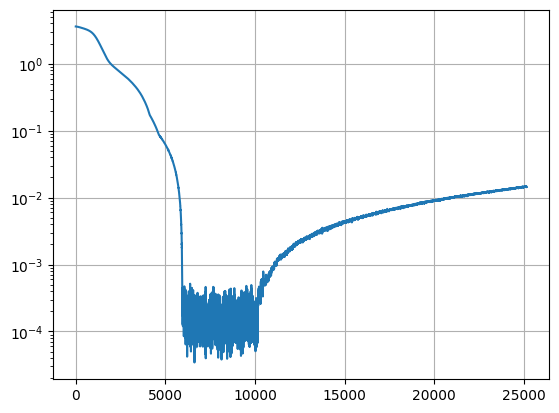

In [36]:
import numpy as np
import matplotlib.pyplot as plt
generator_losses = np.array(out_step_100["losses"]["generator"][1:])
plt.plot(generator_losses)
plt.yscale("log")
plt.grid(True)

In [57]:
generator_0= out_step_0["generator"]
log_lgs_0 = out_step_0["log_lgs"]

oracle_generator = torch.tensor([[0, -1], [1, 0]], dtype=torch.float32, requires_grad=False).unsqueeze(0)
scalar = oracle_generator/log_lgs_0
scalar

tensor([[[ 0.0000, -0.3755],
         [-0.3755,  0.0000]],

        [[ 0.0000,  0.4452],
         [ 0.4453, -0.0000]],

        [[ 0.0000,  0.7101],
         [ 0.7101,  0.0000]]])

In [68]:
def _project_onto_vector_subspace(vecs, basis):
    """
    Projects 1-tensors onto a d-dimensional subspace of 1-tensors.
    vecs: tensor of shape (N, b, d, n)
    basis: tensor of shape (N, b, d, n)
    Returns:
    - proj_vecs: tensor of shape (N, b, d, n)
    - ortho_vecs: tensor of shape (N, b, d, n)
    """
    basis_t = basis.transpose(-2, -1)
    G = torch.matmul(basis, basis_t)
    G_inv = torch.linalg.pinv(G)
    P = torch.matmul(basis_t, torch.matmul(G_inv, basis))
    proj_vecs = torch.matmul(vecs, P)
    return proj_vecs, vecs-proj_vecs

def _project_onto_tensor_subspace(tensors: torch.tensor, basis:torch.tensor):
    """
    Projects 2-tensors onto a d-dimensional subspace of 2-tensors.
    Args:
    - tensors: torch.tensor of shape (b, n, n), b two-tensors
    - basis: torch.tensor of shape (d, n, n), a d-dimensional vector space of two-tensors, given by its basis.

    Returns: 
    - proj: torch.tensor of shape (b, n, n), the projection of tensors onto the subspace spanned by basis
    - ortho_comp: torch.tensor of shape (b, n, n), the orthogonal complement of tensors with respect to the subspace spanned by basis.
    """
    b,n,_= tensors.shape
    d,_,_= basis.shape
    tensors_flat=tensors.reshape(b, n*n)
    basis_flat=basis.reshape(d, n*n)


    proj_vecs_flat, ortho_vecs_flat = _project_onto_vector_subspace(tensors_flat, basis_flat)
    proj = proj_vecs_flat.reshape(b, n, n)
    ortho_comp = ortho_vecs_flat.reshape(b, n, n)
    return proj, ortho_comp

In [217]:
torch.manual_seed(42)
generator_0=torch.randn(1, 2, 2, requires_grad=True)
w_0 = torch.randn(3, requires_grad=True)
generator_0_weight = generator_0.clone().detach().requires_grad_()
generator_0_span = generator_0.clone().detach().requires_grad_()
optim_generator= torch.optim.Adam([generator_0_weight, w_0], lr=0.0035)
optim_span= torch.optim.Adam([generator_0_span], lr=0.0035)


N_epochs=2_000

def weight_optimization(w_0, log_lgs_0, generator_0, optimizer):
    losses= []
    span_losses= []
    for _ in range(N_epochs):
        optimizer.zero_grad()
        generator_normed = generator_0 / torch.linalg.matrix_norm(generator_0, dim=(1, 2), keepdim=True)
        log_lgs_hat = torch.einsum("N,dmn->Nmn", w_0, generator_normed)
        loss = torch.mean((log_lgs_hat - log_lgs_0) ** 2)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        with torch.no_grad():
            _, ortho_comp = _project_onto_tensor_subspace(log_lgs_0, generator_0)
            span_loss = torch.mean(torch.linalg.matrix_norm(ortho_comp),dim=0)
            span_losses.append(span_loss.item())
    return np.array(losses), np.array(span_losses), generator_0, w_0

def span_optimization(log_lgs_0, generator_0, optimizer):

    span_losses=[]

    for _ in range(N_epochs):
        optimizer.zero_grad()

        generator_normed = generator_0 / torch.linalg.matrix_norm(generator_0, dim=(1, 2), keepdim=True)
        _, ortho_comp = _project_onto_tensor_subspace(log_lgs_0, generator_normed)
        span_loss = torch.mean(torch.linalg.matrix_norm(ortho_comp),dim=0)

        span_loss.backward()
        optimizer.step()

        span_losses.append(span_loss.item())

    return np.array(span_losses), generator_0

In [213]:
import time

start_weight = time.time()
losses, span_losses_weights, generator_star_weights, w_star_weights = weight_optimization(w_0, log_lgs_0, generator_0_weight, optim_generator)
end_weight = time.time()
print(f"weight_optimization took {end_weight - start_weight:.2f} seconds")

# Timing span_optimization
start_span = time.time()
span_losses_span, generator_star_span = span_optimization(log_lgs_0, generator_0_span, optim_span)
end_span = time.time()
print(f"span_optimization took {end_span - start_span:.2f} seconds")

weight_optimization took 26.66 seconds
span_optimization took 29.15 seconds


In [167]:
lrs=[0.1, 0.01, 0.001]
N_runs=3

all_span_losses = np.zeros((N_epochs, N_runs, len(lrs)))
all_weight_losses = np.zeros((N_epochs, N_runs, len(lrs)))

for idx_run in range(N_runs):
    generator_0=torch.randn(1, 2, 2, requires_grad=True)
    w_0 = torch.randn(3, requires_grad=True)
    for idx_lr, lr in enumerate(lrs):
        generator_0_weight = generator_0.clone().detach().requires_grad_()
        generator_0_span = generator_0.clone().detach().requires_grad_()
        w_0_run = w_0.clone().detach().requires_grad_()
        optim_generator = torch.optim.Adam([generator_0_weight, w_0], lr=lr)
        optim_span = torch.optim.Adam([generator_0_span], lr=lr)

        _, span_losses_weights, generator_0_weight, w_0 = weight_optimization(w_0, log_lgs_0, generator_0_weight, optim_generator)
        span_losses_span, generator_0_span = span_optimization(log_lgs_0, generator_0_span, optim_span)

        all_weight_losses[:, idx_run, idx_lr] = span_losses_weights
        all_span_losses[:, idx_run, idx_lr] = span_losses_span

In [218]:
losses, span_losses_weights, generator_star_weights, w_star_weights = weight_optimization(w_0, log_lgs_0, generator_0_weight, optim_generator)
span_losses_span, generator_star_span = span_optimization(log_lgs_0, generator_0_span, optim_span)

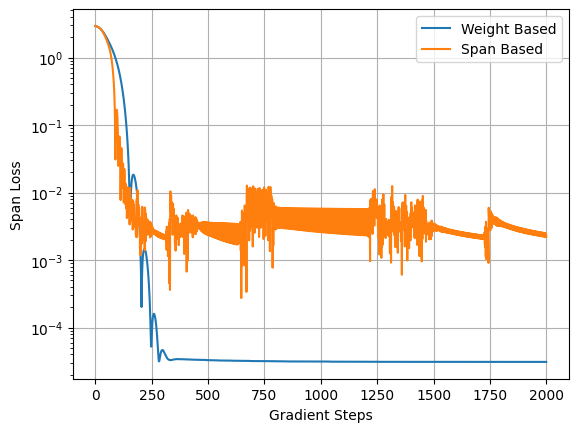

In [219]:
import matplotlib.pyplot as plt
plt.plot(span_losses_weights, label="Weight Based")
plt.plot(span_losses_span, label="Span Based")
plt.yscale("log")
plt.grid()
plt.xlabel("Gradient Steps")
plt.ylabel("Span Loss")
plt.legend()

In [39]:
lgs_0 = torch.matrix_exp(out_step_0["log_lgs"])
lgs_100 = torch.matrix_exp(out_step_100["log_lgs"])
lgs_200 = torch.matrix_exp(out_step_200["log_lgs"])
# lgs_300 = torch.matrix_exp(out_step_300["log_lgs"])

print("lgs at step 0:\n", lgs_0)
print("lgs at step 100:\n", lgs_100)
print("lgs at step 200:\n", lgs_200)
# print("lgs at step 300:\n", lgs_300)

print("generator at step 0:\n", out_step_0["generator"])
print("generator at step 100:\n", out_step_100["generator"])
print("generator at step 200:\n", out_step_200["generator"])
# print("generator at step 300:\n", out_step_300["generator"])

lgs at step 0:
 tensor([[[-0.8877,  0.4606],
         [-0.4605, -0.8877]],

        [[-0.6250, -0.7806],
         [ 0.7806, -0.6250]],

        [[ 0.1619, -0.9868],
         [ 0.9868,  0.1619]]])
lgs at step 100:
 tensor([[[-0.8988,  0.4686],
         [-0.4718, -0.8946]],

        [[-0.6325, -0.7870],
         [ 0.7862, -0.6393]],

        [[ 0.1596, -0.9962],
         [ 0.9980,  0.1510]]])
lgs at step 200:
 tensor([[[-0.9152,  0.4788],
         [-0.4858, -0.9055]],

        [[-0.6431, -0.7968],
         [ 0.7946, -0.6588]],

        [[ 0.1569, -1.0098],
         [ 1.0131,  0.1368]]])
generator at step 0:
 tensor([[[-1.2900e-05,  9.7363e-01],
         [-9.7359e-01, -2.4495e-05]]])
generator at step 100:
 tensor([[[-8.8130e-03,  9.6548e-01],
         [-9.6519e-01, -4.7916e-04]]])
generator at step 200:
 tensor([[[-0.0215,  0.9947],
         [-0.9929, -0.0021]]])


In [4]:
her_geo_dis.generator

Parameter containing:
tensor([[[-6.0437e-06, -5.4854e-02],
         [ 5.4203e-02,  3.0285e-05]]], requires_grad=True)

In [5]:
her_geo_dis.lgs

tensor([[[-0.8919,  0.4562],
         [-0.4475, -0.8919]],

        [[-0.6130, -0.7982],
         [ 0.7808, -0.6126]],

        [[ 0.1772, -0.9955],
         [ 0.9743,  0.1775]]], grad_fn=<LinalgMatrixExpBackward0>)

In [6]:
for param in her_geo_dis.encoder.parameters():
    print(param.data)

tensor([[1.0099e+00, 2.3543e-04],
        [1.7655e-04, 9.8977e-01]])
tensor([-0.0041, -0.0023])


In [7]:
for param in her_geo_dis.decoder.parameters():
    print(param.data)

tensor([[ 9.8997e-01, -5.9011e-04],
        [-4.0776e-04,  1.0104e+00]])
tensor([0.0041, 0.0022])
